<H1>A Machine Learning Approach to Classifying Honeypots</H1>
<a href=https://github.com/codydbarr/Honeybear>GitHub Repo for all code and training data</a>

<h2>Problem Statement</h2>
<p>
Honeypots are a type of deceptive security technology. They are hosts intentionally designed to attract threat actors, luring them into attacking the honeypot instead of other systems on the network [1]. Honeypots notify defenders of interactions with suspected threat actors, collect activity logs for analysis by incident responders, and hinder adversaries by consuming their time and resources [3].  
</p>
<p>
This research aims to develop a machine learning based system to classify honeypots within a network. For penetration testers, the results should improve stealth and help avoid wasting limited time and resources on honeypots during testing engagements.
</p>


<h2>Data Acquisition</h2>
<p>
The process began with data acquisition. Since no readily available data sources were available, I assembled my own.  
</p>
<p>
Shodan, a database of internet-facing devices, provides a honeypot tag along with host data such as port scan results, location information, domain names, hostnames, and reported vulnerabilities. This honeypot tag is used as the label for the supervised models trained later in this study. 
</p>
<p>
The amount of data available from Shodan is immense. However, my API access to Shodan limited the scope of this dataset, so I augmented the process with FOFA, a similar competitor. The process is detailed in the diagram below. A key aspect of the data collection was the initial analysis of regions with the highest percentage of honeypots and the 50 most common ports among all hosts in those regions. This provided sufficient real-world examples of honeypots, which represent the minority class in the dataset. 
</p>
<p>
The honeypot tag is an assumption central to this model. We recognize that the Shodan label cannot be perfectly accurate, but for simplicity, we treat it at face value.
</p>
<p align="center">
    <img src="https://github.com/codydbarr/Honeybear/raw/refs/heads/main/ETL%20Process.png" width="1000">
</p>




<H1>Initial Implementation</H1>

In [20]:
#foundationals
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import IsolationForest #anomaly detection

#Data processing and visualization
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from subprocess import call
from sklearn.tree import export_graphviz
from mpl_toolkits.mplot3d import Axes3D
from sklearn.tree import plot_tree

#warnings.filterwarnings('ignore') #Silence warnings

In [4]:
df = pd.read_csv('honeypot_final.csv')

In [5]:
df.head()

,ip,vulns,os,hostname,domain,total_ports,FTP-Data-20,FTP-Control-21,SSH-22,Telnet-23,...,MongoDB-27017,Redis-6379,Elasticsearch-9200,Cassandra-9042,Memcached-11211,Zookeeper-2181,well_known_ports,registered_ports,ephemeral_ports,isHoneypot
0,41.174.183.86,588,NaN,swagoldendusk.xyz,swagoldendusk.xyz,1000,1,1,1,1,...,0,1,0,1,0,1,109,890,0,1
1,102.177.75.12,588,NaN,swagoldendusk.xyz,swagoldendusk.xyz,1000,1,1,1,1,...,0,1,0,1,0,1,103,896,0,1
2,181.225.233.229,0,NaN,mail-md.red.geiq.cu,geiq.cu,1000,0,1,0,1,...,0,1,1,1,1,1,92,907,0,1
3,181.225.233.231,0,NaN,none,none,1000,0,1,1,1,...,0,1,1,1,1,1,90,909,0,1
4,41.173.37.43,0,NaN,none,none,1000,1,1,1,1,...,0,1,1,1,1,1,83,916,0,1


<h3>About the Data</h3>
<p>
The data initially pulled from Shodan and FOFA exceeded 150GB of XML. During initial processing, I extracted the fields I considered relevant and reformatted them into a more manageable CSV file.  
</p>
<p>
The dataset includes vulnerabilities that Shodan believes may be present in each system, along with hostname and domain information, and most importantly, open ports.  
</p>
<p>
I selected the 50 most common ports observed across all hosts in the dataset that mapped to real services and created a truth table. A value of 0 indicates the port is closed, while 1 indicates the port is open. Totals for all ports present on each host, as well as separate totals for well-known, registered, and ephemeral ports, are also provided.  
</p>
<p>
As previously mentioned, the honeypot tag serves as the y label.  
</p>


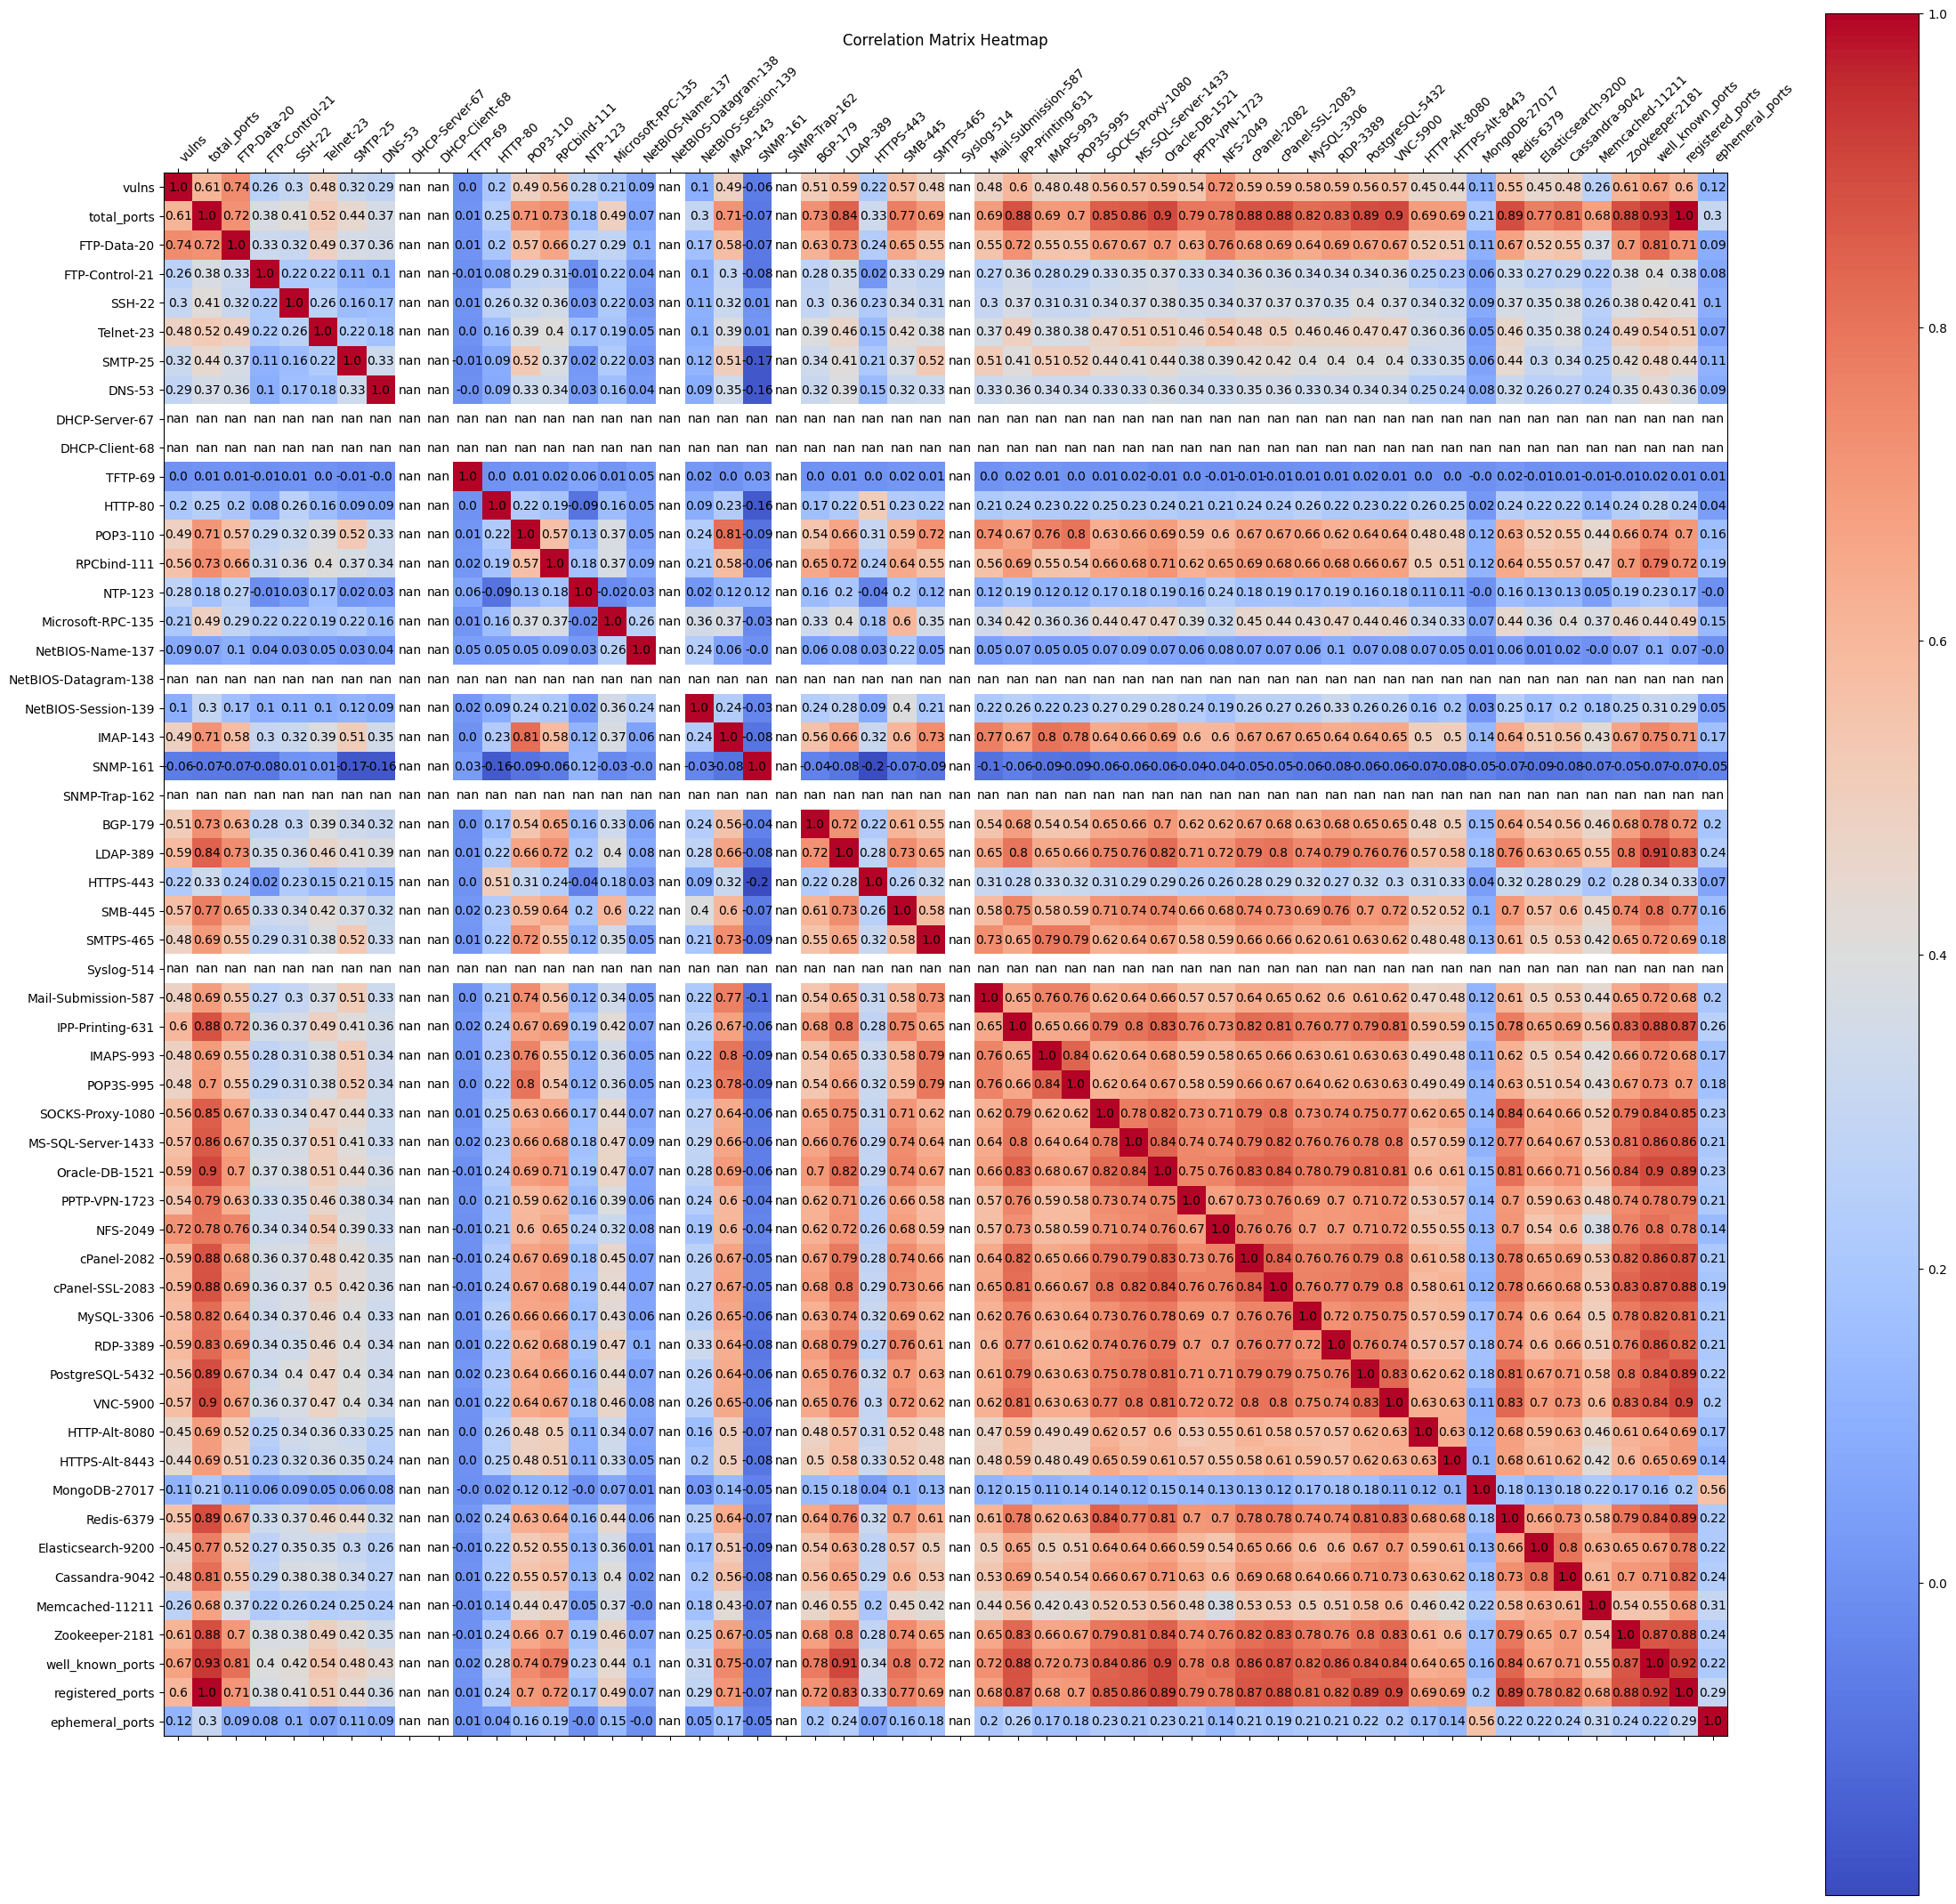

In [6]:
# Compute the correlation matrix
df1=df.drop(columns=['ip','os','domain','hostname','isHoneypot'])#remove columns that are not in the final dataset
corr_matrix = df1.corr()

# Plot heatmap using Matplotlib
fig, ax = plt.subplots(figsize=(24, 22))
cax = ax.matshow(corr_matrix, cmap='coolwarm')

# Add colorbar
fig.colorbar(cax)

# Set axis ticks and labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='left')
ax.set_yticklabels(corr_matrix.columns)

# Annotate correlation values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = round(corr_matrix.iloc[i, j], 2)
        ax.text(j, i, str(value), va='center', ha='center', color='black')

plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()


<h3>Correlation</h3>
<p>
The correlation matrix provides several noteworthy insights into the dataset, which will be examined in greater detail through subsequent feature selection and anomaly detection.  
</p>
<p>
Certain ports exhibit strong correlations with one another, reflecting logical associations between related protocols. For instance, POP3 and IMAP are both email inbox services and naturally demonstrate a high correlation (0.81), which aligns with their functions. In contrast, ports that are widely deployed, such as HTTP port 80, display low correlation with most other ports. This outcome is likely attributable to their ubiquity across diverse systems, reducing the strength of association with any specific service.  
</p>
<p>
To evaluate feature importance and to model their interactions, the initial models will be trained using the complete set of features presented here.  
</p>


In [7]:
# Select columns
x_labels1 = df.columns[list(range(1, 2)) + list(range(5, 58))] #removes the categorical variables that do not contribute to classification

X = df[x_labels1].copy() # keep as DataFrame for easier manipulation

# Convert to numpy array if needed
X = np.array(X.values)

print(x_labels1)

Index(['vulns', 'total_ports', 'FTP-Data-20', 'FTP-Control-21', 'SSH-22',
       'Telnet-23', 'SMTP-25', 'DNS-53', 'DHCP-Server-67', 'DHCP-Client-68',
       'TFTP-69', 'HTTP-80', 'POP3-110', 'RPCbind-111', 'NTP-123',
       'Microsoft-RPC-135', 'NetBIOS-Name-137', 'NetBIOS-Datagram-138',
       'NetBIOS-Session-139', 'IMAP-143', 'SNMP-161', 'SNMP-Trap-162',
       'BGP-179', 'LDAP-389', 'HTTPS-443', 'SMB-445', 'SMTPS-465',
       'Syslog-514', 'Mail-Submission-587', 'IPP-Printing-631', 'IMAPS-993',
       'POP3S-995', 'SOCKS-Proxy-1080', 'MS-SQL-Server-1433', 'Oracle-DB-1521',
       'PPTP-VPN-1723', 'NFS-2049', 'cPanel-2082', 'cPanel-SSL-2083',
       'MySQL-3306', 'RDP-3389', 'PostgreSQL-5432', 'VNC-5900',
       'HTTP-Alt-8080', 'HTTPS-Alt-8443', 'MongoDB-27017', 'Redis-6379',
       'Elasticsearch-9200', 'Cassandra-9042', 'Memcached-11211',
       'Zookeeper-2181', 'well_known_ports', 'registered_ports',
       'ephemeral_ports'],
      dtype='object')


In [8]:
y = df['isHoneypot'].values # the honeypot class label 0=not a honeypot, 1=honeypot

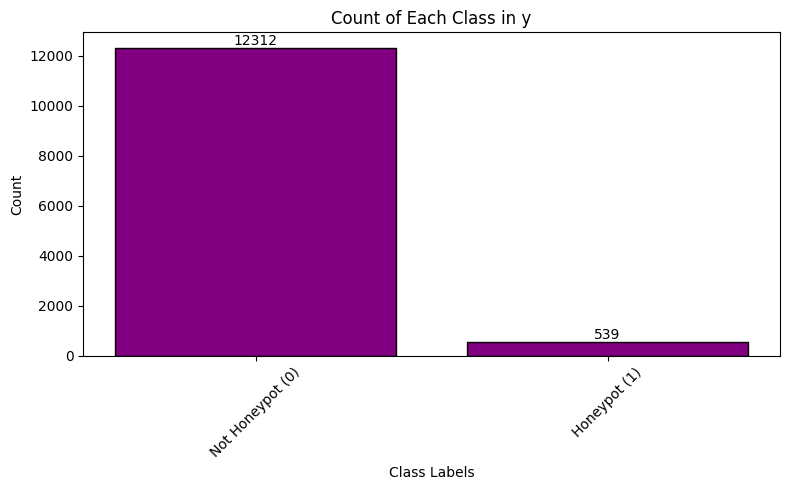

In [9]:
# Count unique values
labels, counts = np.unique(y, return_counts=True)
labels=["Not Honeypot (0)","Honeypot (1)"]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color='Purple', edgecolor='black')

# Add count labels on top of each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, str(count),
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Count of Each Class in y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h3>Class Distribution</h3>
<p>
The data acquisition process from Shodan and FOFA was deliberately structured to include a sufficient number of honeypot examples for model training, which proved successful. Although honeypots represent a minority class, comprising approximately 4% of the dataset, the models were able to learn effectively from this distribution.  
</p>
<p>
I also experimented with Synthetic Minority Oversampling Technique (SMOTE) to artificially increase the number of honeypot instances. However, these oversampling procedures did not yield measurable improvements in the performance of any of the evaluated models.  
</p>


In [11]:
# Initialize MinMaxScaler
#scaler = MinMaxScaler() #commented out after experimentation proved detrimental
#X_scale = scaler.fit_transform(X) #commented out after experimentation proved detrimental, all variables already same scale as binary 0,1

#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

#Use SMOTE oversampling to address imbalance in the dataset
#sm = SMOTE(sampling_strategy=0.2, k_neighbors=3, random_state=10) #commented out after experimentation proved detrimental
#X_train, y_train = sm.fit_resample(X_train, y_train)

<H3>Feature Selection & Analysis</H3>

In [14]:
#Create a decision tree, just for feature selection
tree_ent = DecisionTreeClassifier(criterion = "entropy", random_state = 10, max_depth=6, min_samples_leaf=5)
tree_ent.fit(X_train, y_train)

#Get performance Metrics
y_pred = tree_ent.predict(X_test)
#print(classification_report(y_test, y_pred, digits=4))

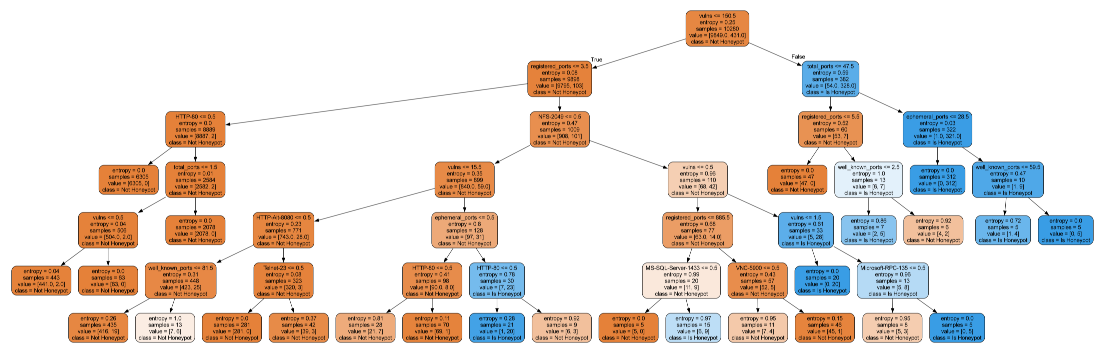

In [15]:
# Export as dot file
export_graphviz(tree_ent, out_file='tree.dot', 
                feature_names = x_labels1,
                class_names = ['Not Honeypot', 'Is Honeypot'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display
plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('tree.png'))
plt.axis('off');

plt.show();

In [16]:
#helper function for feature importance
def get_feature_importance(tree, feature_names):
    importances = tree.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    return importance_df

#get feature importance
imp=get_feature_importance(tree_ent, x_labels1)
print(imp[:13])

               Feature  Importance
0                vulns    0.692939
52    registered_ports    0.151660
1          total_ports    0.081085
36            NFS-2049    0.023213
53     ephemeral_ports    0.018871
11             HTTP-80    0.009780
51    well_known_ports    0.006904
43       HTTP-Alt-8080    0.004261
5            Telnet-23    0.003862
42            VNC-5900    0.003053
33  MS-SQL-Server-1433    0.002279
15   Microsoft-RPC-135    0.002093
4               SSH-22    0.000000


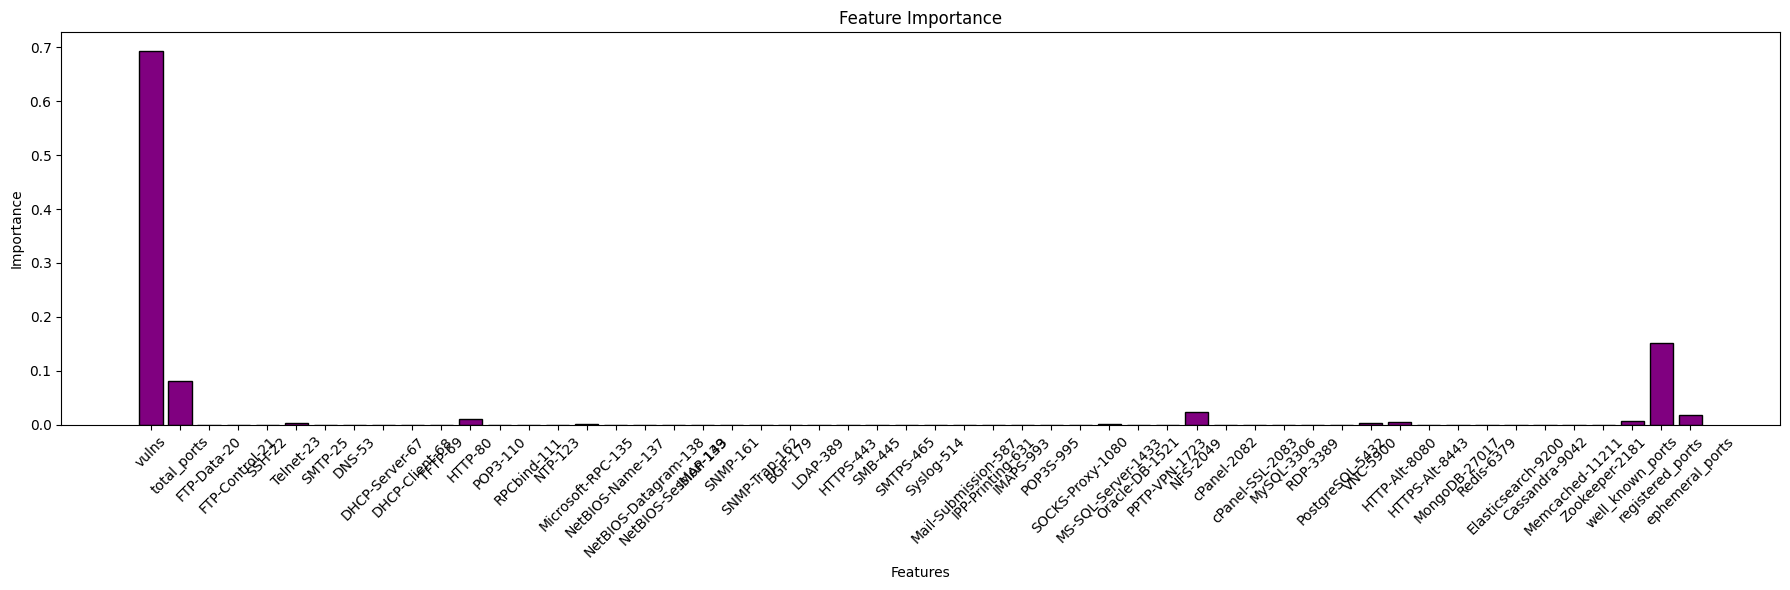

In [18]:
#gather feature importance from the decision tree for bar graph
importances = tree_ent.feature_importances_
plt.figure(figsize=(18, 6))
bars = plt.bar(x_labels1, importances, color='purple', edgecolor='black')

#display
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h3>Decision Tree Feature Importance</h3>
<p>
An analysis of feature importance using a decision tree model indicates that the vulnerability count feature overwhelmingly dominates the decision-making process. This outcome is unsurprising, as honeypots are deliberately configured to appear vulnerable to attract threat actors. The vulnerability count accounts for nearly 70% of the total feature importance.  
</p>
<p>
Registered ports and total ports collectively contribute 23% of the importance, which aligns with expected honeypot behavior. All remaining features individually contribute less than 3% each, providing minimal influence on the model’s decisions.  
</p>
<p>
A logistic regression model will also be trained, employing L1 regularization for feature selection. The results will be compared to the decision tree  for confirmation.  
</p>


In [30]:
# a log reg model ALSO for feature selection, this is confirmation

# Initialize MinMaxScaler (default range [0, 1])
scaler = MinMaxScaler() #helped speed up the L1 log reg model convergence

# Fit and transform the data
X_scale = scaler.fit_transform(X)

#Scaling the data for better processing by Logistic Regression
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_scale, y, test_size=0.2, random_state=10, stratify=y)

# Perform feature selection using logisitc regression with L1 regularization
logreg_l1 = LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=10, max_iter=1000)

# Fit the data
logreg_l1.fit(X_train_s, y_train_s)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,10
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


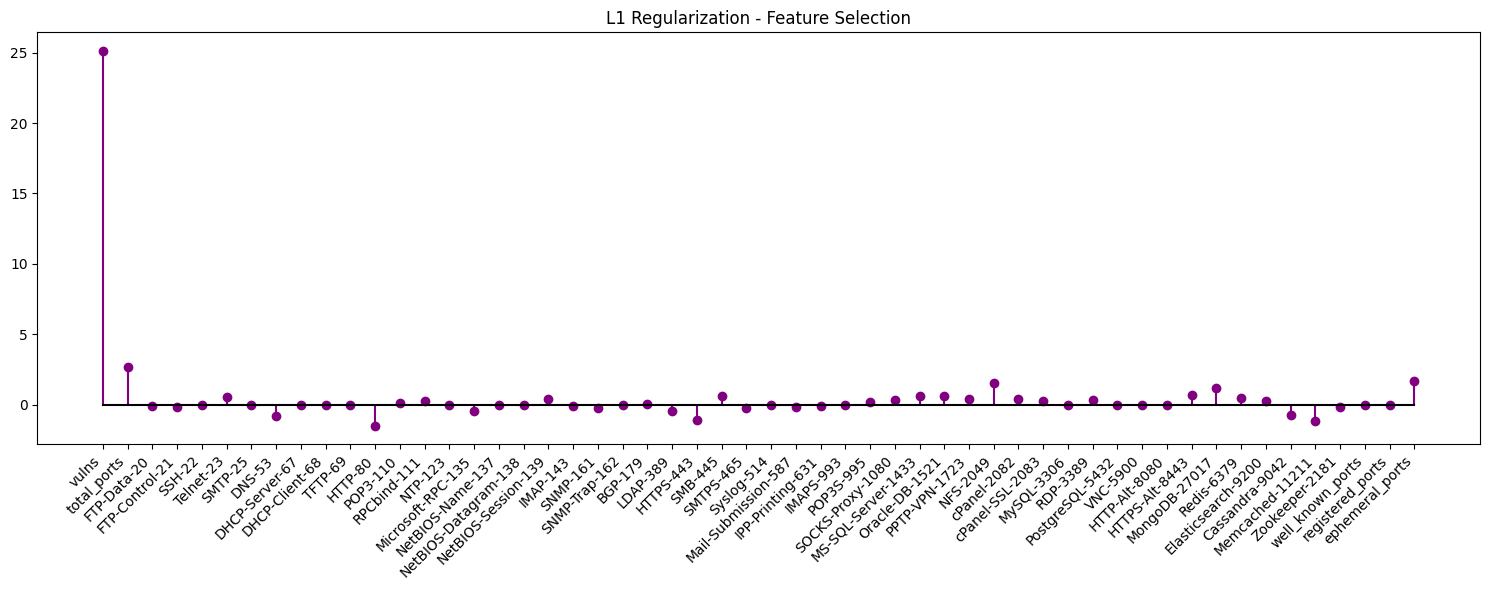

In [29]:
#display feature selection stem plot

W = logreg_l1.coef_.flatten()
feature_names = x_labels1
fig, axes = plt.subplots(1, 1, figsize=(15, 6))
axes.stem(W, linefmt='purple', markerfmt='o', basefmt='k')
axes.set_title("L1 Regularization - Feature Selection")

# Add feature names at the bottom
axes.set_xticks(range(len(W)))
axes.set_xticklabels(x_labels1, rotation=45, ha='right', fontsize=10)

#display
plt.tight_layout()
plt.show()


<h3>Feature Analysis</h3>
<p>
The L1-regularized logistic regression model corroborates the importance of several features identified by the decision tree. The vulnerability count remains the most influential data in the feature set, followed closely by the aggregated port counts.  
</p>
<p>
Where the logistic regression model diverges, however, is in its assignment of additional importance to specific individual ports, such as SMB port 445. The relatively high importance for a single service will prove useful later in this study.  
</p>
<p>
The initial models will be trained and evaluated using the complete feature set to establish a baseline before pruning impractical features.  
</p>


<h1>Model Comparison - All Features</h1>

In [39]:
#store results for all models
results=[]

# Logistic Regression
log_reg = LogisticRegression(
    penalty='l2',          # L2 (Ridge) regularization, helps prevent overfitting by penalizing large coefficients
    C=0.01,                # regularization rate is strong
    max_iter=500,          
    class_weight={0:1, 1:2}, # adjusted higher weight for class 1 (positive class) to handle imbalance; class 1 is twice as important
    random_state=10      
)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))
results.append(classification_report(y_test, y_pred, digits=4 , output_dict=True)) #add results to list for later graphing

              precision    recall  f1-score   support

           0     0.9907    0.9943    0.9925      2463
           1     0.8586    0.7870    0.8213       108

    accuracy                         0.9856      2571
   macro avg     0.9246    0.8907    0.9069      2571
weighted avg     0.9851    0.9856    0.9853      2571



In [40]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,        # num of trees in the forest
    max_depth=10,            # limits complexity to prevent overfitting
    min_samples_leaf=5,      # helps enforce generalization by avoiding overly small leaves
    random_state=10,        
    class_weight={0:1, 1:4}  # adjusted higher weight for class 1 (positive class) to handle imbalance; honeypot is 4x more penalty than 0
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))
results.append(classification_report(y_test, y_pred, digits=4 , output_dict=True)) #add results to list for later graphing

              precision    recall  f1-score   support

           0     0.9947    0.9980    0.9964      2463
           1     0.9500    0.8796    0.9135       108

    accuracy                         0.9930      2571
   macro avg     0.9724    0.9388    0.9549      2571
weighted avg     0.9929    0.9930    0.9929      2571



In [41]:
# AdaBoost
ada = AdaBoostClassifier(
    estimator=tree_ent,     # a decision tree with entropy criterion
    n_estimators=100,       # num of boosting rounds; builds 100 sequential weak learners (trees)
    learning_rate=0.1,      # contribution rate of each weak learner
    random_state=10        
)


ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))
results.append(classification_report(y_test, y_pred, digits=4 , output_dict=True)) #add results to list for later graphing

              precision    recall  f1-score   support

           0     0.9955    0.9988    0.9972      2463
           1     0.9700    0.8981    0.9327       108

    accuracy                         0.9946      2571
   macro avg     0.9828    0.9485    0.9649      2571
weighted avg     0.9945    0.9946    0.9945      2571



In [42]:
# Assemble comparison table
model_names=["Logreg","Rand Forest","AdaBoost"]
not_honeypot_f1=[]
honeypot_f1=[]
a=[]
m=[]
w=[]
for result in results:
    #print(result)
    not_honeypot_f1.append(result['0']['f1-score'])
    honeypot_f1.append(result['1']['f1-score'])
    a.append(result['accuracy'])
    m.append(result['macro avg']['f1-score'])
    w.append(result['weighted avg']['f1-score'])

comparison = {
    'Model': model_names,
    'Not Honeypot':not_honeypot_f1,
    'Honeypot':honeypot_f1,
    'Accuracy': a,
    'Macro Average': m,
    'Weighted Average': w
}

comparison_table = pd.DataFrame(comparison)

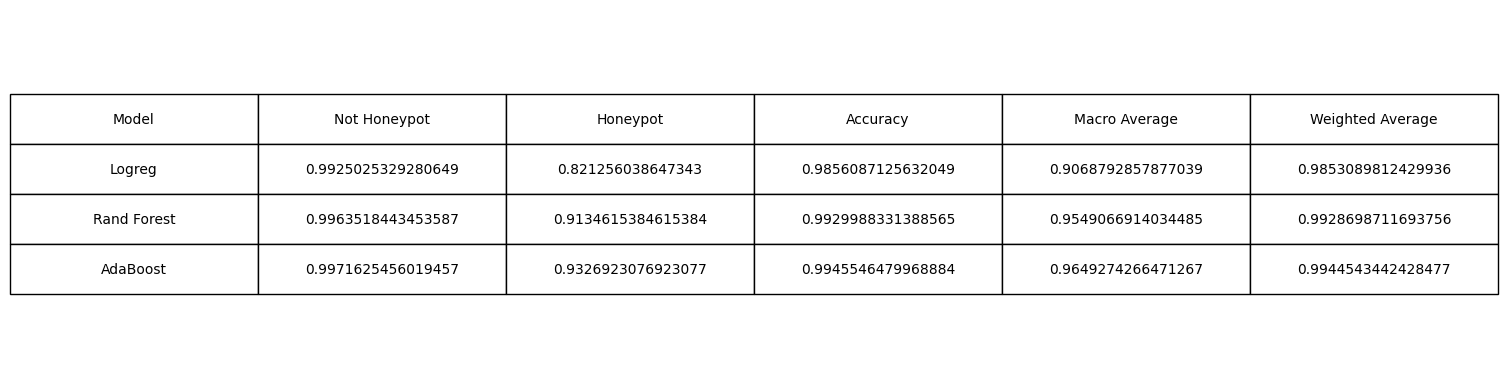

In [43]:
# Create a figure and axis
fig, ax = plt.subplots()

# Hide axes
ax.axis('off')

# Create table
table = ax.table(
    cellText=comparison_table.values,
    colLabels=comparison_table.columns,
    cellLoc='center',
    loc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(3, 3)
plt.show()

<h3>Model Performance Analysis</h3>
<p>
Each model was selected for its ability to provide probabilistic determinations. In the practical application we will pursue later, we will want to output the probability that a given host is a honeypot. Therefore, Logistic Regression, Random Forest, and Gradient Boosting through the AdaBoost model were implemented.  
</p>
<p>
All three models performed well on the majority class (non-honeypots), achieving F1 scores above 0.99. This is trivial given the class imbalance. Because of the class imbalance, accuracy alone is a misleading metric since it does not fully reflect performance on the minority class.  
</p>
<p>
The honeypot class posed a more difficult classification challenge, and highlighted the differences among the models. Logistic Regression struggled compared to the ensemble methods, yielding an F1 score of only 0.821. Random Forest improved upon this result, achieving an F1 score of 0.913 and demonstrating a more balanced performance. AdaBoost, the boosting ensemble model, attained the highest F1 score for honeypot classification at 0.933. Notably, Random Forest slightly outperformed AdaBoost in precision, but was substantially outperformed in recall.  
</p>
<p>
Overall, AdaBoost emerges as the top performer, excelling in both minority and majority class detection. AdaBoost’s superior F1 score for honeypots makes it our primary candidate for real-world deployment.
</p>


<h1>Reducing Dimensionality</h1>
<p>
As demonstrated above, the models achieved strong performance in classifying honeypots when trained on the full feature set. However, this feature set is not practical for real-world use. Vulnerability counts and the aggregated port totals were the most influential features, but they are resource-intensive to obtain from a live system. Vulnerability scanning is time-consuming and intrusive, increasing the likelihood of detection. Similarly, calculating total port counts requires exhaustive sequential scanning, which also elevates the risk of exposure.  
</p>
<p>
To address these challenges, the feature set will be reduced to include only the raw port numbers. This approach minimizes network noise and decreases the time required for penetration testers to collect the necessary information.  
</p>
<p>
Usually, feature reduction would focus on eliminating attributes with lower statistical importance. In this case, however, the prioritization is driven by real-world practicality. The following experiments will evaluate the feasibility of honeypot classification using only open ports.  
</p>


In [50]:
# Select columns
x_labels1 = df.columns[list(range(6, 55))]
#removing the vuln count and port count aggregations

X = df[x_labels1].copy()
X = np.array(X.values)
print(x_labels1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y) #split again off new X

Index(['FTP-Data-20', 'FTP-Control-21', 'SSH-22', 'Telnet-23', 'SMTP-25',
       'DNS-53', 'DHCP-Server-67', 'DHCP-Client-68', 'TFTP-69', 'HTTP-80',
       'POP3-110', 'RPCbind-111', 'NTP-123', 'Microsoft-RPC-135',
       'NetBIOS-Name-137', 'NetBIOS-Datagram-138', 'NetBIOS-Session-139',
       'IMAP-143', 'SNMP-161', 'SNMP-Trap-162', 'BGP-179', 'LDAP-389',
       'HTTPS-443', 'SMB-445', 'SMTPS-465', 'Syslog-514',
       'Mail-Submission-587', 'IPP-Printing-631', 'IMAPS-993', 'POP3S-995',
       'SOCKS-Proxy-1080', 'MS-SQL-Server-1433', 'Oracle-DB-1521',
       'PPTP-VPN-1723', 'NFS-2049', 'cPanel-2082', 'cPanel-SSL-2083',
       'MySQL-3306', 'RDP-3389', 'PostgreSQL-5432', 'VNC-5900',
       'HTTP-Alt-8080', 'HTTPS-Alt-8443', 'MongoDB-27017', 'Redis-6379',
       'Elasticsearch-9200', 'Cassandra-9042', 'Memcached-11211',
       'Zookeeper-2181'],
      dtype='object')


In [51]:
#Another decision tree for feature importance
tree_ent = DecisionTreeClassifier(criterion = "entropy", random_state = 10,
                               max_depth=6, min_samples_leaf=5)
tree_ent.fit(X_train, y_train)
#Get performance Metrics
y_pred = tree_ent.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9871    0.9968    0.9919      2463
           1     0.9048    0.7037    0.7917       108

    accuracy                         0.9844      2571
   macro avg     0.9459    0.8502    0.8918      2571
weighted avg     0.9837    0.9844    0.9835      2571



In [52]:
#get feature importance
imp=get_feature_importance(tree_ent, x_labels1)
print(imp[:30]) #29 features with weight this time instead of just 12

               Feature  Importance
34            NFS-2049    0.707484
38            RDP-3389    0.057580
12             NTP-123    0.041845
35         cPanel-2082    0.039635
0          FTP-Data-20    0.030697
48      Zookeeper-2181    0.018485
3            Telnet-23    0.015727
32      Oracle-DB-1521    0.013630
13   Microsoft-RPC-135    0.011034
42      HTTPS-Alt-8443    0.008969
43       MongoDB-27017    0.007274
21            LDAP-389    0.004881
28           IMAPS-993    0.004545
23             SMB-445    0.004014
9              HTTP-80    0.003970
27    IPP-Printing-631    0.003540
18            SNMP-161    0.003338
47     Memcached-11211    0.003309
5               DNS-53    0.003250
31  MS-SQL-Server-1433    0.002767
11         RPCbind-111    0.002678
39     PostgreSQL-5432    0.002022
45  Elasticsearch-9200    0.001954
40            VNC-5900    0.001705
22           HTTPS-443    0.001504
20             BGP-179    0.001432
36     cPanel-SSL-2083    0.001413
24           SMTPS-4

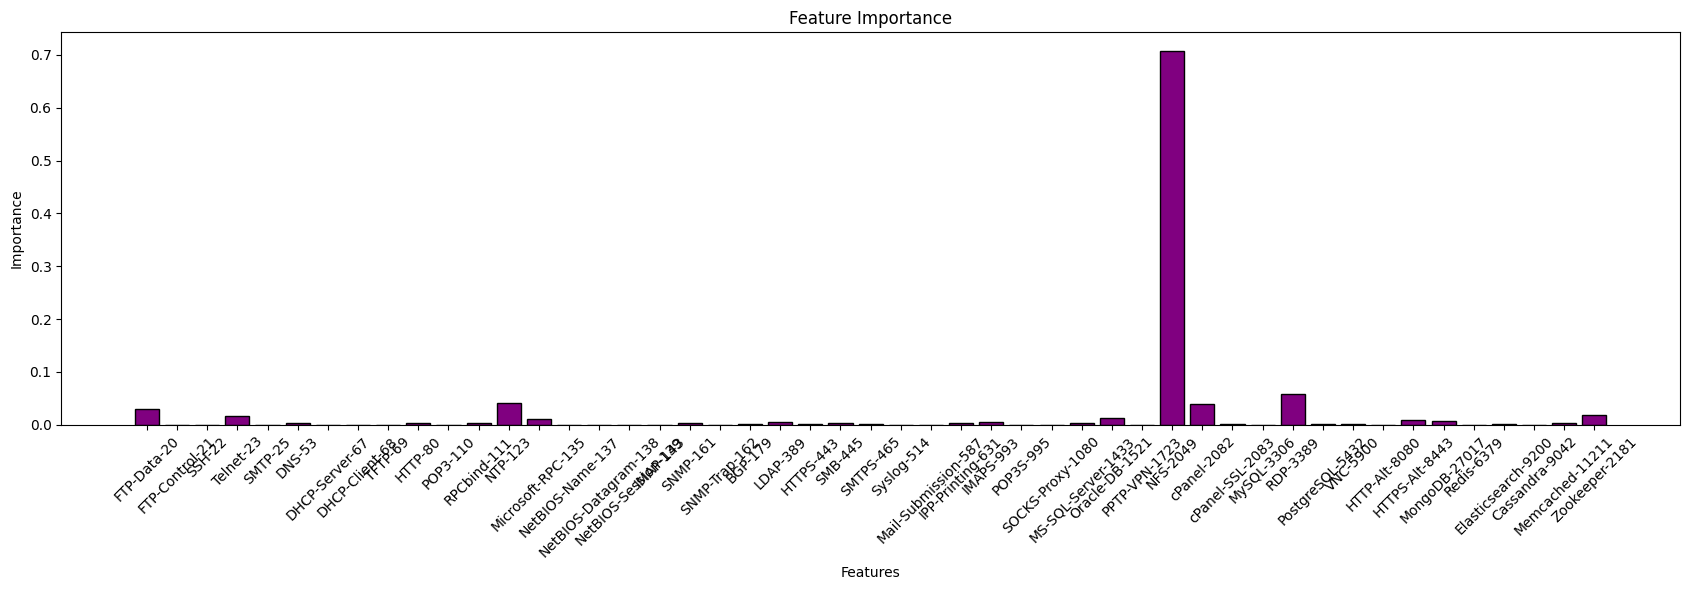

In [53]:
#display feature importance as a bar graph for new dataset
importances = tree_ent.feature_importances_
plt.figure(figsize=(17, 6))
bars = plt.bar(x_labels1, importances,
               color='purple', edgecolor='black')

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<h2>Feature Analysis</h2>
<p>
Following the removal of vulnerability scan data and aggregated port counts, the distribution of feature importance shifted considerably.  
</p>
<p>
A decision tree was again used to gather feature importance. This time, NFS port 2049 dominates the model’s decision-making process, accounting for more than 70% of the total importance. Despite the presence of this dominant feature, a broader set of ports now contributes meaningfully to the model. Specifically, RDP, NTP, cPanel, and FTP collectively account for approximately 17% of the importance, with numerous other ports providing incremental adjustments to the classification process.  
</p>
<p>
For practical application in penetration testing, this distribution is positive, since it shows that honeypot classification can be achieved using a reduced set of port based features rather than relying on intensive vulnerability data or aggregated counts.  
</p>


<h1>Model Comparison - Reduced Feature Set</h1>

In [73]:
#store results for all models
results=[]

# Logistic Regression
log_reg = LogisticRegression(
    penalty='l2', # L2 (Ridge) regularization, helps prevent overfitting by penalizing large coefficients
    C=0.01, # regularization rate is strong
    max_iter=500,
    random_state=10 
)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))
results.append(classification_report(y_test, y_pred, digits=4 , output_dict=True))

              precision    recall  f1-score   support

           0     0.9843    0.9931    0.9887      2463
           1     0.8023    0.6389    0.7113       108

    accuracy                         0.9782      2571
   macro avg     0.8933    0.8160    0.8500      2571
weighted avg     0.9767    0.9782    0.9770      2571



In [74]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=200, # num of trees in the forest
    max_depth=10, # limits complexity to prevent overfitting
    min_samples_leaf=5, # helps enforce generalization by avoiding overly small leaves
    random_state=10, 
    class_weight={0:1, 1:4} # adjusted higher weight for class 1 (positive class) to handle imbalance; honeypot is 4x more
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))
results.append(classification_report(y_test, y_pred, digits=4 , output_dict=True))

              precision    recall  f1-score   support

           0     0.9911    0.9907    0.9909      2463
           1     0.7890    0.7963    0.7926       108

    accuracy                         0.9825      2571
   macro avg     0.8900    0.8935    0.8917      2571
weighted avg     0.9826    0.9825    0.9825      2571



In [75]:
# AdaBoost
ada = AdaBoostClassifier(
    estimator=tree_ent, # a decision tree with entropy criterion
    n_estimators=50, # num of boosting rounds; builds 100 sequential weak learners (trees)
    learning_rate=0.1, # contribution rate of each weak learner
    random_state=10
)

ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))
results.append(classification_report(y_test, y_pred, digits=4 , output_dict=True))

              precision    recall  f1-score   support

           0     0.9868    0.9984    0.9925      2463
           1     0.9494    0.6944    0.8021       108

    accuracy                         0.9856      2571
   macro avg     0.9681    0.8464    0.8973      2571
weighted avg     0.9852    0.9856    0.9845      2571



In [76]:
# Assemble comparison table
model_names=["Logreg","Rand Forest","AdaBoost"]
not_honeypot_f1=[]
honeypot_f1=[]
a=[]
m=[]
w=[]
for result in results:
    #print(result)
    not_honeypot_f1.append(result['0']['f1-score'])
    honeypot_f1.append(result['1']['f1-score'])
    a.append(result['accuracy'])
    m.append(result['macro avg']['f1-score'])
    w.append(result['weighted avg']['f1-score'])

comparison = {
    'Model': model_names,
    'Not Honeypot':not_honeypot_f1,
    'Honeypot':honeypot_f1,
    'Accuracy': a,
    'Macro Average': m,
    'Weighted Average': w
}

comparison_table = pd.DataFrame(comparison)

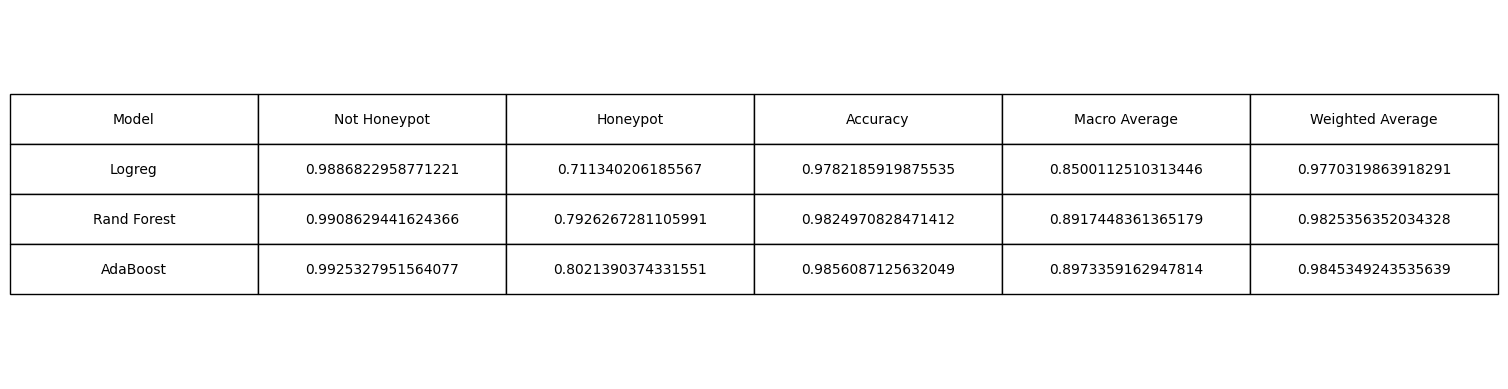

In [77]:
# Create a figure and axis
fig, ax = plt.subplots()

# Hide axes
ax.axis('off')

# Create table
table = ax.table(
    cellText=comparison_table.values,
    colLabels=comparison_table.columns,
    cellLoc='center',
    loc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(3, 3)
plt.show()

<h3>Model Performance Analysis</h3>
<p>
With the reduced feature set, all models exhibited a decline in overall performance.  
</p>
<p>
Logistic Regression continued to struggle with honeypot classification, producing results that fall short of the threshold required for practical application.  
</p>
<p>
Random Forest demonstrated superior recall, which contributed most significantly to its improved F1 score relative to Logistic Regression.  
</p>
<p>
AdaBoost once again achieved the strongest performance among the three models, delivering results that remain acceptable for practical application. It consistently outperformed Logistic Regression across all metrics and was surpassed only by Random Forest in recall for the minority honeypot class.  
</p>


<h1>Anomaly Detection</h1>
<p>
In addition to exploring honeypot detection through supervised learning models, it became evident that such data could also serve a valid role in anomaly detection. To experiment with anomaly detection we employed Isolation Forest, an unsupervised learning model, to identify anomalies within the dataset with the aim of distinguishing honeypots.  
</p>
<p>
Isolation Forest was selected for its effectiveness in handling high-dimensional data, such as such as our dataset. The algorithm constructs an ensemble of isolation trees, each generated through random partitioning of features. Anomalies are identified by requiring fewer partitions to isolate them, meaning that instances located on shorter branches (shorter path lengths) within the trees are more likely to be anomalous.  
</p>


In [78]:
clf = IsolationForest(
    n_estimators=200,      # number of trees
    max_samples="auto",    # subsample size for each tree
    contamination=0.06,    # expected proportion of outliers
    max_features=1.0,      # number of features per split
    bootstrap=False,       # whether to bootstrap samples
    random_state=10        # reproducibility
)

clf.fit(X_train)

# Predict anomalies
anomalies = clf.predict(X_test) 
decision_scores=clf.decision_function(X_test)
raw_scores=clf.score_samples(X_test)

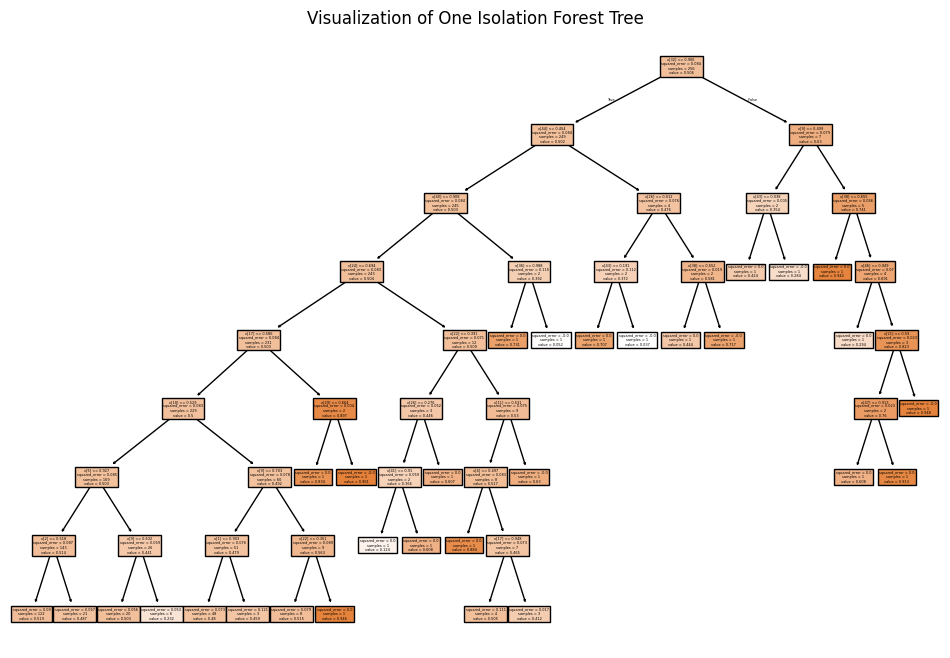

In [80]:
#Display one tree in the Isolation forest 
one_tree = clf.estimators_[0]

#visualize the tree
plt.figure(figsize=(12,8))
plot_tree(one_tree, filled=True)
plt.title("Visualization of One Isolation Forest Tree")
plt.show()

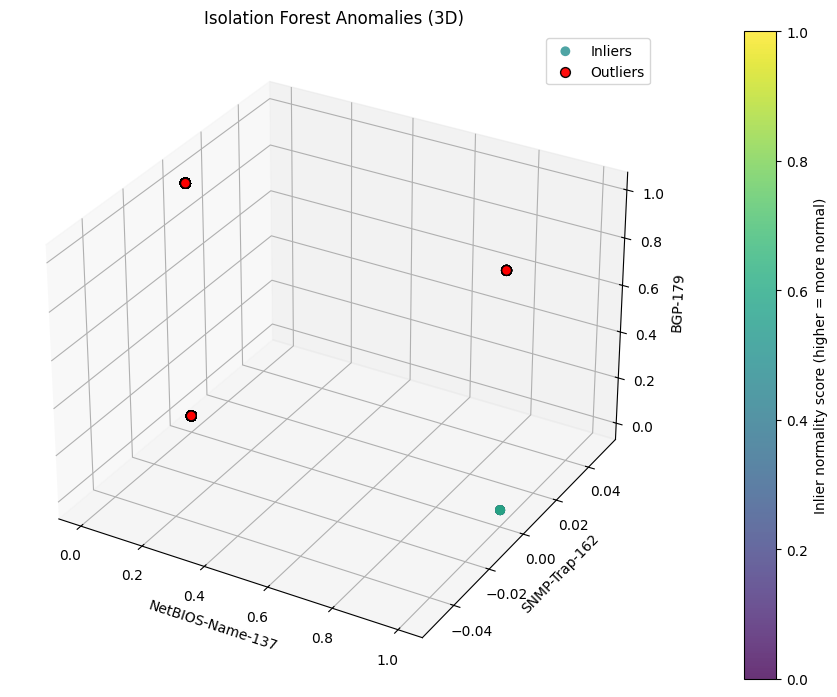

In [86]:
#3D graph showing how inliers cluster together, and outliers are scattered apart

j=14
k=19
h=20
# scores
labels = clf.predict(X)      # +1 inlier, -1 outlier
scores = clf.decision_function(X)  # higher = more normal, lower = more anomalous

# scatter plot
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
inliers = labels == 1
outliers = labels == -1
s_min, s_max = scores[inliers].min(), scores[inliers].max()
norm_scores = (scores[inliers] - s_min) / (s_max - s_min + 1e-12)

# plot inliers
p_in = ax.scatter(
    X[inliers, j], X[inliers, k], X[inliers, h],
    c=norm_scores, cmap='viridis', s=50, alpha=0.8, edgecolor='none',
    label='Inliers'
)

# plot outliers
p_out = ax.scatter(
    X[outliers, j], X[outliers, k], X[outliers, h],
    c='red', s=50, alpha=0.95, edgecolor='k',
    label='Outliers'
)

ax.set_title('Isolation Forest Anomalies (3D)')
ax.set_xlabel(x_labels1[j])
ax.set_ylabel(x_labels1[k])
ax.set_zlabel(x_labels1[h])
ax.legend(loc='upper right')

cbar = fig.colorbar(p_in, ax=ax, shrink=1, pad=0.1)
cbar.set_label('Inlier normality score (higher = more normal)')

plt.tight_layout()
plt.show()
j+=1
k+=1
h+=1


<h2>Isolation Tree Example</h2>
<p>
The tree visualization above depicts a single tree within the Isolation Forest ensemble. The primary objective of the tree is to partition records into progressively smaller subsets, thereby isolating individual instances. Anomalous records are characterized by shorter average path lengths across the ensemble of trees, as they require fewer partitions to be separated from the rest of the data. In the visualization, these anomalies are denoted in dark orange.  
</p>
<p>
As another example, the 3D graph depicts inliers and outliers in the data based on the interaction of 3 features. Inliners cluster together, making them more difficult to seperate in a tree. Outliers are easier to seperate in a tree since they are distributed, as shown in the 3D graph. When the Isolation tree is formed, the records with the shortest paths were easier to seperate, and therefore the most likely to be anomalies. 
</p>


<p>I uploaded an easier to view tree image here: https://github.com/codydbarr/Honeybear/blob/main/isolation_tree.png</p>

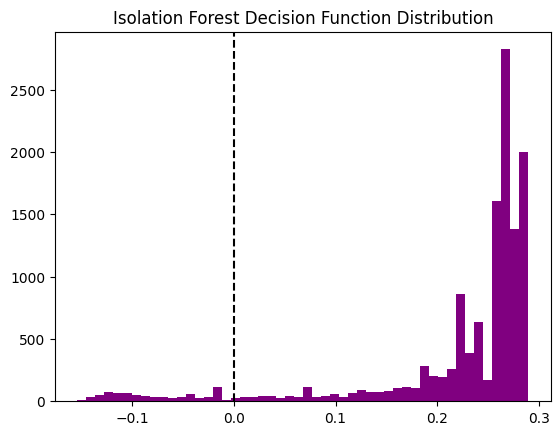

In [83]:
#Show decision boundary defined by the contamination feature
scores = clf.decision_function(X)
plt.hist(scores, bins=50, color='purple')
plt.axvline(0, color='black', linestyle='--')
plt.title("Isolation Forest Decision Function Distribution")
plt.show()

<h2>Contamination Variable</h2>
<p>
A critical parameter in training the Isolation Forest is the "contamination" variable. This parameter specifies the expected proportion of anomalies within the dataset. For this study, we have the benefit of the honeypot label. Accordingly, the contamination value was set to 6%, slightly above the observed 4% representation of honeypots in the data.  
</p>
<p>
The chart above maps the distribution of the decision function, which is directly influenced by the contamination parameter. This visualization highlights how the contamination setting governs the threshold for anomaly classification.  
</p>


In [84]:
#normalize the anomaly output to be compared better with the supervised learning models
#I recognize this is not an appropriate comparison given their fundamental differences in purpose, this is just illustrative
i=0
count_honey_anomaly=0
count_honey_normal=0
count_normal_anomaly=0
count_normal_normal=0
while( i < len(anomalies)):
    if(anomalies[i]<0 and y_test[i]>0):
        # a honeypot that was marked as an anomaly
        count_honey_anomaly+=1
    elif(anomalies[i]>0 and y_test[i]>0):
        # a honeypot that was marked as normal
        count_honey_normal+=1
    elif(anomalies[i]<0 and y_test[i]==0):
        # a normal host marked as an anomaly
        count_normal_anomaly+=1
    else:
        count_normal_normal+=1
    if(anomalies[i]==1):
        anomalies[i]=0
    elif(anomalies[i]==-1):
        anomalies[i]=1
    i+=1

print(classification_report(y_test, anomalies, digits=4))

              precision    recall  f1-score   support

           0     0.9909    0.9683    0.9795      2463
           1     0.5244    0.7963    0.6324       108

    accuracy                         0.9611      2571
   macro avg     0.7576    0.8823    0.8059      2571
weighted avg     0.9713    0.9611    0.9649      2571



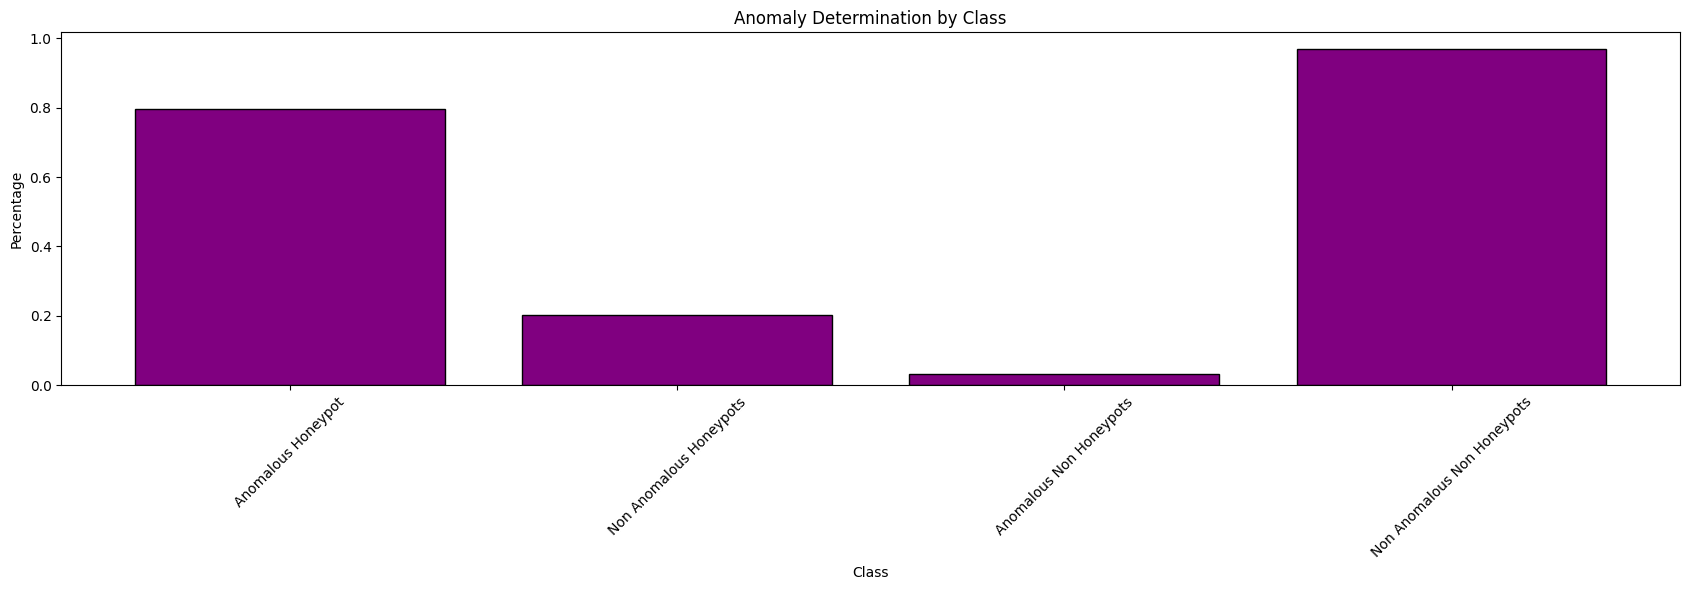

In [87]:
#Display the distribution of anomalies by class
percentages=[count_honey_anomaly/108, count_honey_normal/108, count_normal_anomaly/2463, count_normal_normal/2463]
a_labels=["Anomalous Honeypot", "Non Anomalous Honeypots", "Anomalous Non Honeypots", "Non Anomalous Non Honeypots"]
plt.figure(figsize=(17, 6))
bars = plt.bar(a_labels, percentages,
               color='purple', edgecolor='black')

plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Anomaly Determination by Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h2>Model Performance</h2>
<p>
Directly comparing the performance of the Isolation Forest to supervised machine learning models is not appropriate, as their objectives are fundamentally different. However, when applied to honeypot detection, the Isolation Forest provides valuable insights into honeypot behavior. In this dataset, nearly 80% of honeypots were identified as anomalous, while only 3% of non-honeypot hosts were classified as anomalies. Surprisingly, the recall for detecting the minority honeypot class was on par with that of random forest, and actually surpassed AdaBoost, though the precision is far lower.   
</p>
<p>
For penetration testers, this information is particularly valuable during the reconnaissance phase. An anomalous host warrants further investigation, as it may represent a honeypot, a misconfigured system, or an asset that simply deviates from expected patterns. Such hosts can then be subjected to targeted honeypot detection using supervised models or vulnerability analysis for further study.  
</p>

<p>All Code files can be found in my Git repo: https://github.com/codydbarr/Honeybear</p>

<h1>Application</h1>
<p>
One of my objectives for this study is the practical application of the developed models.  
</p>
<p>
To operationalize these models, a server/client system was designed and implemented. This system iteratively scans the open ports of a target host and transmits the resulting data to a selected, pretrained model for classification.  
</p>
<p>
The figures below present the architecture diagram of the honeypot classification framework, which we have named "Honeybear". The accompanying screenshots demonstrate its functionality when deployed against a Metasploitable virtual machine, showcasing both AdaBoost classification and Isolation Forest anomaly detection in practice.  
</p>

<a href=https://github.com/codydbarr/Honeybear>GitHub Repo for all code and training data</a>

<img src="https://github.com/codydbarr/Honeybear/raw/refs/heads/main/Honeybear.png" width="800">
<img src="https://github.com/codydbarr/Honeybear/raw/refs/heads/main/meta_scan_ada.png" width="800">
<img src="https://github.com/codydbarr/Honeybear/raw/refs/heads/main/meta_scan_anomaly.png" width="800">

<h2>Conclusion</h2>
<p>
This study has demonstrated the feasibility of applying supervised machine learning models to classify honeypots using a minimalistic dataset. Of the models evaluated, AdaBoost, an adaptive boosting algorithm, achieved the strongest performance, outperforming the other supervised approaches.  
</p>
<p>
The insights derived from feature selection and supervised learning were operationalized into a practical machine learning based tool for honeypot classification. This tool reduces the burden of information gathering, lowering the requirements from vulnerability scans and exhaustive port enumeration to fewer than 50 targeted port scans.  
</p>
<p>
Anomaly detection, applied to the same dataset, also proved feasible, though with mixed effectiveness in isolating honeypots specifically. While anomaly detection is not ideally suited for precise honeypot identification, the results nonetheless provide valuable reconnaissance insights. Anomalous hosts may represent honeypots, misconfigurations, or other non standard systems, all of which warrant further investigation. For this reason, the anomaly detection component was incorporated into the Honeybeartool, complementing the supervised models and enhancing its utility for penetration testing.  
</p>
<p>Future research is needed to explore more lightweight honeypot patterns such as targeted service banners. More research can also be conducted with datasets larger than 13000 hosts, which this study was limited to.</p>


<H1>Sources</H1>
[1] O. Surnin et al., "Probabilistic Estimation of Honeypot Detection in Internet of Things Environment," 2019 International Conference on Computing, Networking and Communications (ICNC), Honolulu, HI, USA, 2019, pp. 191-196, doi: 10.1109/ICCNC.2019.8685566. keywords: {Internet of Things;Botnet;Security;Servers;Linux;Probabilistic logic;Feature extraction;Internet of Things;SSH Honeypots;Intrusion;Security;Attacks},
<br></br>

[2] N. Krawetz, "Anti-honeypot technology," in IEEE Security & Privacy, vol. 2, no. 1, pp. 76-79, Jan.-Feb. 2004, doi: 10.1109/MSECP.2004.1264861.
keywords: {Testing;Electronic mail;Relays;Privacy;Joining processes;Internet;Computer security;Counting circuits;Encoding;Bayesian methods},
<br></br>
[3] M. Tsikerdekis, S. Zeadally, A. Schlesener and N. Sklavos, "Approaches for Preventing Honeypot Detection and Compromise," 2018 Global Information Infrastructure and Networking Symposium (GIIS), Thessaloniki, Greece, 2018, pp. 1-6, doi: 10.1109/GIIS.2018.8635603. keywords: {Botnet;Monitoring;Delays;Organizations;Production;Authentication;Detection;honeypot;protocol;security},
<br></br>
[4] S. Morishita et al., "Detect Me If You… Oh Wait. An Internet-Wide View of Self-Revealing Honeypots," 2019 IFIP/IEEE Symposium on Integrated Network and Service Management (IM), Arlington, VA, USA, 2019, pp. 134-143. keywords: {Open source software;Tools;Security;Servers;Market research;Sociology;Statistics},
<br></br>
[5] M. Brenndoerfer, “Isolation Forest: Complete Guide to Unsupervised Anomaly Detection with Random Trees & Path Length Analysis,” Mbrenndoerfer.com, Nov. 2025. https://mbrenndoerfer.com/writing/isolation-forest-anomaly-detection-unsupervised-learning-random-trees-path-length-mathematical-foundations-python-scikit-learn-guide (accessed Nov. 30, 2025).
<br></br>
[6] S. Raschka and V. Mirjalili, Python machine learning : machine learning and deep learning with python, scikit-learn, and tensorflow 2. Birmingham: Packt Publishing, Limited, 2019.
<br></br>
[7] E. Alpaydin, Introduction to Machine Learning. S.L.: Mit Press, 2020.
